# Variants of stochastic gradient-based optimization

## Steps

1. Setting the scene
2. Stochastic Gradient Descent (SGD) *(implemented)*
3. SGD with adaptive learning rate *(implemented and optimized using grid search)*
4. SGD with momentum *(implemented and optimized using grid search)*
5. SGD with accumulated squared gradient: AdaGrad *(not implemented)*
6. SGD with accumulated squared gradient: RMSProp *(not implemented)*
7. SGD with accumulated squared gradient: ADAM *(not implemented)*


## Setting the scene

During learning, we optimize the mean squared error $MSE$ of the models $m$ for the model parameters $\mathbf w$: 

$$MSE(\mathbf w,m,X,Y) =\frac{1}{N}\sum_{i=1}^{N}(y_i - m(\mathbf w, \mathbf  x_i))^2$$

In other words, we find $\arg\min_{\mathbf w} MSE(\mathbf w, m, X, Y)$.

We will reuse some functions defined in the notebook "Learn an XOR Neural Network using gradient-based optimization" including:
1. The mean squared error function `mse` (loss function).
2. The gradient of the mean squared error function `grad_mse` (gradient of the loss function).
3. The gradient descent function for the loss function `grad_desc_mse`.
4. The 3D surcace and contour plot function `plot3D`.

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def mse(ws, m, X, Y):
    N = len(X)
    err = 0
    for i in range(N):
        y_hat = m(ws, X[i])
        err += (Y[i] - y_hat)**2
    return err / N

def grad_mse(ws, m, grads, X, Y):
    N = len(X)
    M = len(ws)
    grad_ws = np.zeros((M))
    for i in range(N):
        xi = X[i,:]
        yi = Y[i]
        tmp = yi - m(ws, xi)
        for j in range(M):
            grad_ws[j] = grad_ws[j] + tmp*grads[j](ws, xi)
    grad_ws = grad_ws / -2
    return grad_ws

def grad_desc_mse(K, ws, learning_eps, loss, grad_loss, verbose):
    hist = np.zeros((K+1))
    hist[0] = loss(ws)
    for k in range(K):
        grad_ws = grad_loss(ws)
        old_ws = ws
        ws = old_ws - learning_eps * grad_ws
        if verbose:
            plt.plot([old_ws[0], ws[0]], [old_ws[1], ws[1]])

        hist[k+1] = loss(ws)
    return ws, hist

def plot3d(f,A,B,real3d):
    vectorized_func = np.vectorize(f)
    Z = vectorized_func(A,B)
    if real3d:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(A, B, Z, cmap='viridis')
        fig.colorbar(surf, shrink=0.5, aspect=5)
        ax.invert_xaxis() 
    else:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        surf = ax.contour(A, B, Z, cmap='viridis')
        fig.colorbar(surf, shrink=0.5, aspect=5)
    return fig, ax



First we generate sample data points. The generator function is $y=20x_1 -3x_2$. We sample data at integer points $x_{i,1}\times x_{i,2} \in [1\ldots N]\times [1\ldots N], N=100$ and add a random error to $y_i$ that is normally distributed proportional to $\mathcal{N}(0,10)$. 

Below we plot the function.

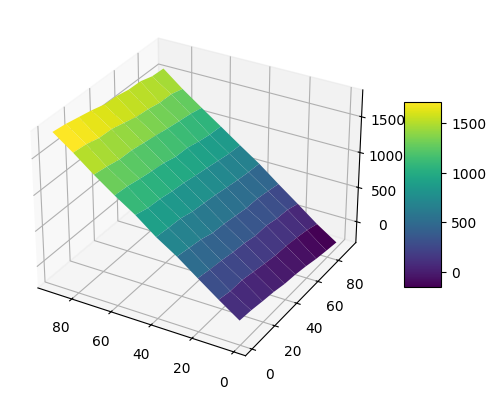

In [57]:
N = 100
XX = np.array(np.meshgrid(np.arange(1,N+1), np.arange(1,N+1))).T.reshape(-1, 2)
a10 = 20
a20 = -3

X1 = XX[:,0]
X2 = XX[:,1]

f0 = lambda x1, x2: a10*x1 + a20*x2
f = lambda x1,x2,r: a10*x1 + a20*x2 + r

np.random.seed(42)
R = np.transpose(np.random.normal(0, 10, len(XX)))
Y = np.vectorize(f)(X1,X2,R)
A,B = np.meshgrid(np.arange(1, N+1, N/10), np.arange(1, N+1, N/10))
ff = lambda x1,x2: f(x1,x2,np.random.normal(0, 10))

plot3d(ff, A,B, True)
plt.show()

The model that we use throughout this notebook is a simple linear Neural Network model. It consists of one neuron connected to the input $\mathbf x$ and an identity, i.e., no effective, activation function. The neuron and the whole model $m_1$ implements $m_1(\mathbf w, \mathbf x) = \mathbf w^T \mathbf x$.

In [58]:
m1 = lambda ws,x: ws[0] * x[0] + ws[1] * x[1]
mse1 = lambda ws: mse(ws, m1, XX, Y)

As the Tensorflow default, we implement the Glorot uniform initializer for setting the initial weights $\mathbf w_0$.
It draws samples from a uniform random distribution within $[-\mathit{limit}, \mathit{limit}]$,
where $\mathit{limit} = \sqrt{\frac{6}{\mathit{in} + \mathit{out}}}$, and
where $\mathit{in}$ and $\mathit{out}$ is the number of input and output units, resp.

In [59]:
import math 
import random

random.seed(42)
input = 2
out = 2
limit = math.sqrt(6 / (input + out))
ws0 = [random.uniform(-limit, limit), random.uniform(-limit, limit)]
print(ws0)

[0.3415245126916837, -1.1634812830144055]


We assess the loss $MSE$ of $m_1$ for this initial weights setting.

In [60]:
mse1(ws0)

1134789.243254444

The gradient of $MSE(\mathbf w)$ for any $\mathbf w$ is defiend as:

$$
\begin{aligned}
\nabla_{MSE}(\mathbf w) &= \left [ 
\frac{\partial MSE(\mathbf w)}{\partial w_1},
\frac{\partial MSE(\mathbf w)}{\partial w_2}
\right ]^T\\
&= \frac{1}{N}\left [ 
\frac{\partial \sum_{i=1}^{N}(y_i - m_1(\mathbf w,\mathbf x_i)^2}{\partial w_1}, 
\frac{\partial \sum_{i=1}^{N}(y_i - m_1(\mathbf w,\mathbf x_i))^2}{\partial w_2} 
\right ]^T \\
&= \frac{1}{N} \left [ 
\sum_{i=1}^{N}2(y_i- m_1(\mathbf w,\mathbf x_i))\frac{-\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_1},
\sum_{i=1}^{N}2(y_i- m_1(\mathbf w,\mathbf x_i))\frac{-\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_2}
\right ]^T \\
&= -\frac{2}{N} \left [ 
\sum_{i=1}^{N}(y_i- m_1(\mathbf w,\mathbf x_i))\frac{\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_1},
\sum_{i=1}^{N}(y_i- m_1(\mathbf w,\mathbf x_i))\frac{\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_2}
\right ]^T \\
\end{aligned}
$$

We can plug in the function $m_1$ and the first derivative of $m_1$ wrt. $w_1$ and $w_2$ resp.

$$
\begin{aligned}
\frac{\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_1} &=\frac{\partial \mathbf w^T\mathbf x_{i}}{\partial w_1} = \frac{\partial w_1 x_{i,1} + w_2 x_{i,2}}{\partial w_1}  =x_{i,1}\\
\frac{\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_2} &=\frac{\partial \mathbf w^T\mathbf x_{i}}{\partial w_2} = \frac{\partial w_1 x_{i,1} + w_2 x_{i,2}}{\partial w_2}  = x_{i,2}\\
\end{aligned}
$$

We have already defined the function $m_1$. Let's also define the functions of the first derivative of $m_1$ wrt. $w_1$ and $w_2$ resp. For the sake of generality, we keep $\mathbf w$ as a formal parameter `ws` even though it is actually not needed for  derivatives of this concrete model $m_1$. 

In [61]:
grad1 = lambda ws, x: x[0]
grad2 = lambda ws, x: x[1]
gradients1 = [grad1, grad2]

The gradient $\nabla_{MSE}(\mathbf w)$ has been defined using $m_1$ and the first derivative of $m_1$ wrt. $w_1$ and $w_2$, resp., as parameters.

The gradient descent function optimizes $\mathbf w$ by iterating over:

$$\mathbf w_{k+1}= \mathbf w_k - \varepsilon \nabla_{MSE}(\mathbf w_k)$$

staring with $\mathbf w_0$.

Below we apply the gradient descent function minimizing $MSE$ for the model $m_1$. We plot the $MSE$ for each step $k$ in the iteration as a function of the current parameter setting $\mathbf w_k$. We also marked the starting point $\mathbf w_0$ with a `+` and the (ideal) minimum $(20, -3)$ with a `*`.

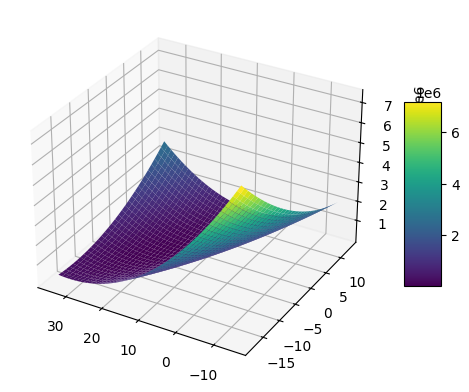

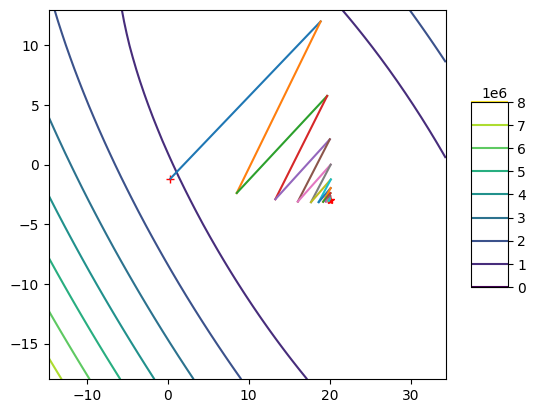

In [62]:
f = lambda a,b : mse1([a,b])

A,B = np.meshgrid(np.arange(min(a10, ws0[0])-15, max(a10,ws0[0])+15), np.arange(min(a20, ws0[1])-15, max(a20,ws0[1])+15))
plot3d(f,A,B, True)
plt.show()

plot3d(f, A, B, False)

plt.plot(a10, a20,'*r')
plt.plot(ws0[0], ws0[1],'+r')

#gradient descent
grad_loss = lambda ws: grad_mse(ws, m1, gradients1, XX, Y)
K = 20
learning_eps = 0.00000006 # needed to change the learning rate. Otherwise I got the problem of overshooting steps.
[ws, history] = grad_desc_mse(K, ws0, learning_eps, mse1, grad_loss, True)



*The history plot shows the convergence of the algorithm. After ca. $k=11$ iterations, the loss $MSE$ is almost zero.*

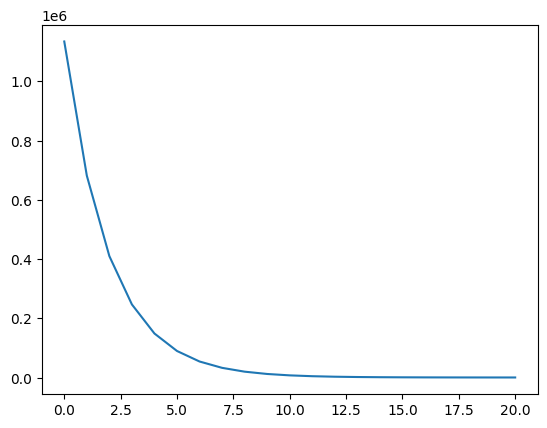

In [63]:
plt.plot(range(len(history)),history)
plt.show()

*I tried it with stochastic gradient decent and the results made me curious ...*

*Hint: I am not shure wheather you interpret the size of the mini batch as a hyper-parameter. Here, I didn't. So this is none of the approaches you wanted me to implement. Anyway, this gives a hint to the size of the learning rate that should be considered for the other approaches. In my opinion, the size of the mini batch is indeed a hyper-parameter. But unfortunately this is limited by the memory space and the size of the input data. Hence, we are not fully free in setting it.*

In [64]:
def stochastic_grad_desc_mse(K, ws, learning_eps, loss, grad_loss, N, verbose):
    batch_size = int(N*0.01)
    hist = np.zeros((K+1))
    hist[0] = loss(ws)
    for k in range(K):
        randices = np.random.choice(np.arange(0, N), size=batch_size, replace=False)
        grad_ws = grad_loss(ws, randices)
        old_ws = ws
        ws = old_ws - learning_eps * grad_ws
        if verbose:
            plt.plot([old_ws[0], ws[0]], [old_ws[1], ws[1]])
        hist[k+1] = loss(ws)
    return ws, hist

*Using the same learning rate, the fitting will not converge after 20 steps.  So it seems that the gradient of the loss for a mini batch is smaller than for all training data.*

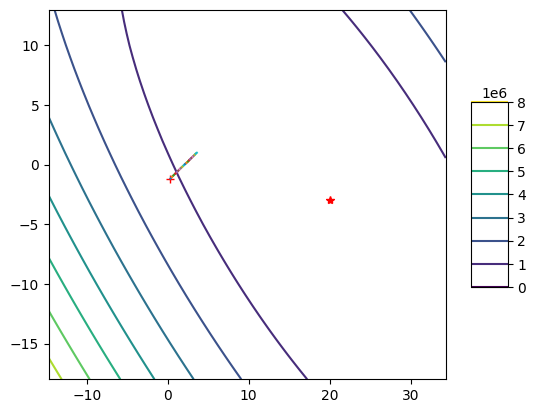

In [65]:
np.random.seed(42)
plot3d(f, A, B, False)
plt.plot(a10, a20,'*r')
plt.plot(ws0[0], ws0[1],'+r')

# SGD
grad_loss2 = lambda ws, randinces: grad_mse(ws, m1, gradients1, XX[randinces, :], Y[randinces])
learning_eps = 0.00000006
[ws, history] = stochastic_grad_desc_mse(K, ws0, learning_eps, mse1, grad_loss2, len(XX), True)

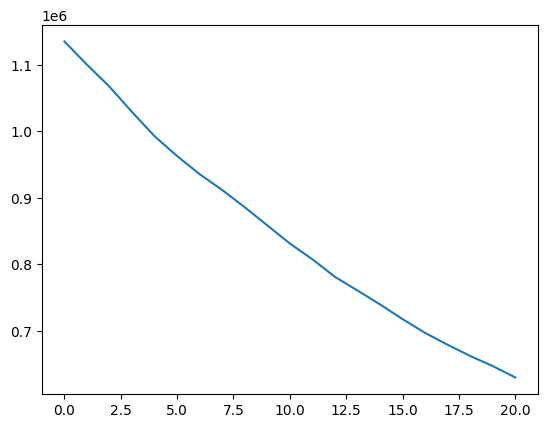

In [66]:
plt.plot(range(len(history)),history)
plt.show()

*Therefore, I used another learning rate of 6e-6 instead of 6e-8.*

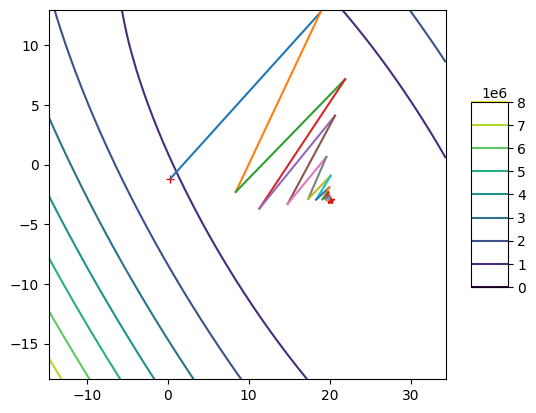

In [67]:
np.random.seed(42)
plot3d(f, A, B, False)
plt.plot(a10, a20,'*r')
plt.plot(ws0[0], ws0[1],'+r')

# SGD
learning_eps = 0.000006
[ws, history] = stochastic_grad_desc_mse(K, ws0, learning_eps, mse1, grad_loss2, len(XX), True)

*Now the fitting converges after approx. $k=11$ steps. However, here were fewer training data used compare to the first approach. Hence, the computational effort is lower.*

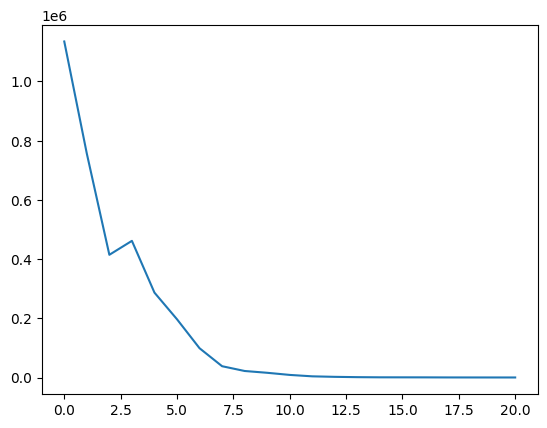

In [68]:
plt.plot(range(len(history)),history)
plt.show()

# *First appraoch with two hyper-parameters*

*Now I start with the approaches using at least two hyper-parameters.*


*The first optimization strategy I choosed is Stochastic Gradient Decent with adaptive learning rate. This approach works with two hyperparameters, i.e. the learning rate $\epsilon$ and the adaption factor of the learning rate $\alpha$*.

## SGD with adaptive learning rate

The learning rate $\varepsilon$ is adapted in each iteration, e.g., exponentially by $\varepsilon_{k+1} = (1-\alpha)\varepsilon_{k}$ with $\alpha$ a new hyper-parameter. 

In [69]:
def stochastic_adaptive_grad_desc_mse(K, ws, learning_eps, loss, grad_loss, N, alpha, verbose):
    batch_size = int(N*0.01)
    hist = np.zeros((K+1))
    hist[0] = loss(ws)
    for k in range(K):
        randices = np.random.choice(np.arange(0, N), size=batch_size, replace=False)
        grad_ws = grad_loss(ws, randices)
        old_ws = ws
        ws = old_ws - learning_eps * grad_ws
        learning_eps = (1-alpha) * learning_eps
        if verbose:
            plt.plot([old_ws[0], ws[0]], [old_ws[1], ws[1]])
        hist[k+1] = loss(ws)
    return ws, hist

*Now I need to define a grid based approach to search for the optimal hyper-parameters. When tuning the hyper-parameter for a model I should consider cross validation. However, I assume that this excercise is about the advantages and disadvantages of the optimization strategies. Therefore, I neglected cross validataion and performed an ordinary grid search.*

In [70]:
np.random.seed(42)

param_grid = {
    'learning_eps': [6e-5, 3e-5, 1e-5, 8e-6, 7e-6, 6e-6, 5e-6, 3e-6, 1e-6, 8e-7, 6e-7],
    'alpha': [1e-5,3e-5,1e-4,3e-4,1e-3,3e-3,1e-2,3e-2]
}

best_score = 10000000
best_params = None

for learning_eps in param_grid['learning_eps']:
    for alpha in param_grid['alpha']:
        [ws, history] = stochastic_adaptive_grad_desc_mse(K, ws0, learning_eps, mse1, grad_loss2, len(XX), alpha, False)
        
        score = mse1(ws)
        if score < best_score:
            best_score = score
            best_params = {'learning_eps': learning_eps, 'alpha': alpha}

print(best_params)
print(best_score)



{'learning_eps': 7e-06, 'alpha': 0.03}
105.66775641165586


*Here, the optimal hyper-parameter according to my search are:*
- $\varepsilon = 7e-6$
- $\alpha = 0.03$

*Now I plugged it into the algorithm again and plotted the history of the search and the learning rate.*

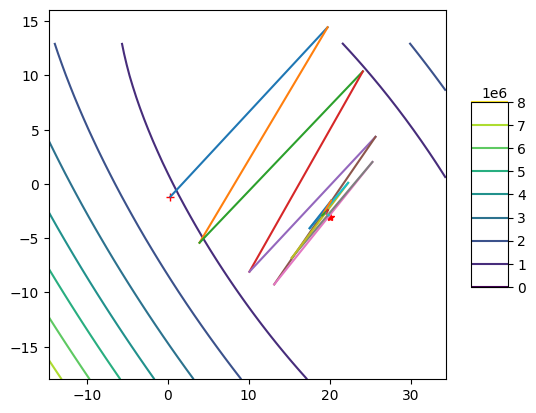

In [71]:
plot3d(f, A, B, False)
plt.plot(a10, a20,'*r')
plt.plot(ws0[0], ws0[1],'+r')

[ws, history1] = stochastic_adaptive_grad_desc_mse(K, ws0, best_params['learning_eps'], mse1, grad_loss2, len(XX), best_params['alpha'], True)


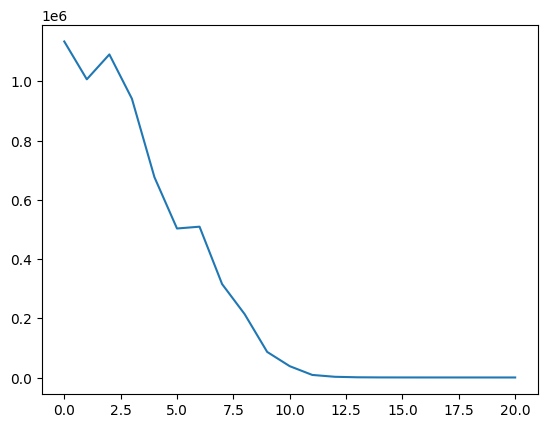

In [72]:
plt.plot(range(len(history1)), history1)
plt.show()

# TODO Here, this describtion doesn't match the diagrams!!!!

*The loss increases in the first 5 steps, before it goes straight down to a value almost zero. The gradient seems to jump from left to right (one cliff to another), which let me assume that the minimum is located in a narrow valley. It looks like the gradient got optimized first in one direction, moving horizontal over the minimum, and then going deep very fast.*

*Here it is case, that the weights/parameters went into the completely wrong direction during the first 5 steps due to a overshooting gradient in one of the two directions. Then it turned the direction and went into the direction where the optimum can be found. However, it needs approximately 12 steps to reach a loss that is almost zero.*


*In conclusion I would say, that in this case the approach is able to compensate for a learning rate that was initialized a way to high. So without the adaption by the alpha parameter, this learning would not converge, since the gradients would have gotten greater and greater.*

*However, I could have done the grid search on a more detailed base. Additionally, I want to notice that the grid search is based on the loss as a score. That gives the hyper-parameters that are best for the model to find the 'best' minimum. But it does not ensure that the minimum is found in a more straight forward way as we saw in the notebooks shown in the course.*

# *Second appraoch with two hyper-parameters*

*I decided to choose SDG with momentum as the second approach. This approach comes with two hyper-parameters, i.e. the learning rate $\varepsilon$ and the mass $m$ used to calculate the momentum.*

## SGD with momentum 

The gradient can be understood as a velocity at which we move towards the optimum. In this analogy, momentum $p$ is introduced as the velocity $v$ (gradient) times mass $m$, a new hyper-parameter of the algorithm. The velocity is set to the average of past gradients (with importance of past velocities decaying exponentially). The initial velocity $v_0$ is the initial gradient. 

**OBS!** The velocity (earlier gradient vectors) and the current gradient vector point "uphill", i.e, into the inverse direction of the expected minimum. They should, hence, be **both** subtracted from the current parameters. 

In [73]:
def stochastic_grad_desc_mse_with_momentum(K, ws, learning_eps, loss, grad_loss, N, mass, verbose):
    batch_size = int(N*0.01)
    hist = np.zeros((K+1))
    hist[0] = loss(ws)
    v = 0
    for k in range(K):
        randices = np.random.choice(np.arange(0, N), size=batch_size, replace=False)
        grad_ws = grad_loss(ws, randices)
        v = (v+grad_ws)/2
        old_ws = ws
        ws = old_ws - v * mass - learning_eps * grad_ws
        if verbose:
            plt.plot([old_ws[0], ws[0]], [old_ws[1], ws[1]])
        hist[k+1] = loss(ws)
    return ws, hist

*Now I performed the oridinary grid search again*

In [74]:
np.random.seed(42)

params = np.linspace(1/10*6e-6, 11/10*6e-6, 20)

param_grid = {
    'learning_eps': params.tolist(),
    'mass': params.tolist()
}

best_score = 10000000
best_params = None

for learning_eps in param_grid['learning_eps']:
    for mass in param_grid['mass']:
        [ws, history] = stochastic_grad_desc_mse_with_momentum(K, ws0, learning_eps, mse1, grad_loss2, len(XX), mass, False)
        
        score = mse1(ws)
        if score < best_score:
            best_score = score
            best_params = {'learning_eps': learning_eps, 'mass': mass}

print(best_params)
print(best_score)



{'learning_eps': 4.3894736842105266e-06, 'mass': 2.1789473684210528e-06}
100.68627282001975


*Here, the optimal hyper-parameter according to my search are:*
- $\varepsilon = 4.3894736842105266 *10^{-6}$
- $m = 2.1789473684210528*10^{-6}$

*Now I plugged it into the algorithm again and plotted the history of the search and the learning rate.*

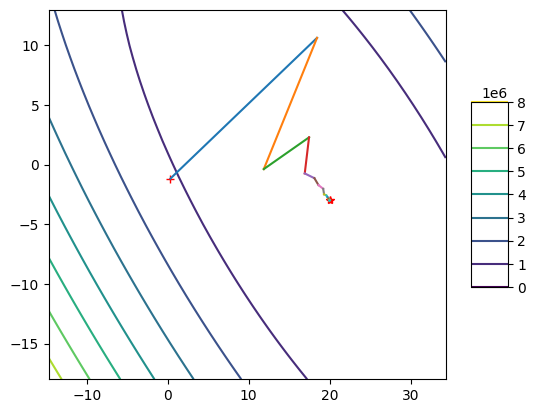

In [75]:
plot3d(f, A, B, False)
plt.plot(a10, a20,'*r')
plt.plot(ws0[0], ws0[1],'+r')

[ws, history2] = stochastic_grad_desc_mse_with_momentum(K, ws0, best_params['learning_eps'], mse1, grad_loss2, len(XX), best_params['mass'], True)


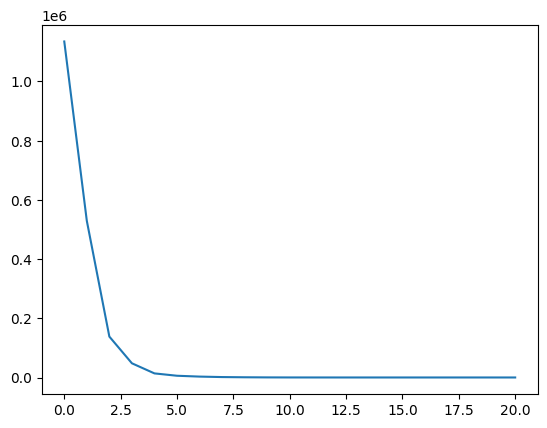

In [76]:
plt.plot(range(len(history2)), history2)
plt.show()

*Interpretation of SGD with momentum:*

# *Comparison*

*Here I plotted the learning rates of the two approaches choosen in one diagram*

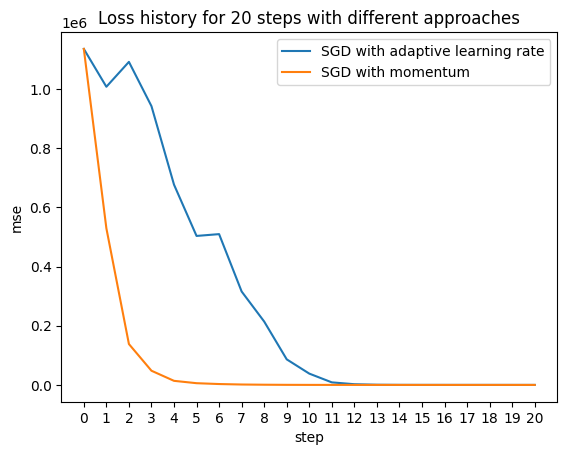

In [83]:
plt.plot(range(len(history1)), history1, label='SGD with adaptive learning rate')
plt.plot(range(len(history2)), history2, label='SGD with momentum')
plt.title('Loss history for 20 steps with different approaches')
plt.legend()
plt.ylabel('mse')
plt.xlabel('step')
plt.xticks(range(len(history2)))
plt.show()

*Interpretation:*